# Multiport Networks Exposed to Multiple Temperatures and Quantum Behavior

The goal of this notebook is to

1. provide examples that correctly handle high frequencies and/or low temperatures using the hyperbolic cotangent thermal model [4],
2. provide examples on how to calculate noise temperature of combined networks that are high in frequency and/or very cold,
3. and similarly provide examples on how to calculate noise figure of combined networks  

we do so with examples of increasingly complex multiport networks. Additionally, the excercises will be verified against seminal texts that inspired the noise covariance and thermal codes of scikit-rf. 

The final example of this notebook is of a set of attenuators spanning across multiple thermal bounaries. This example demonstrates the usefulness of scikit-rf's ability to correctly calculate noise parameters when various components are held at different temperatures. Such capabilities are needed when testing networks that have components passing through cryogenic chambers.


In [2]:
import skrf as rf
import numpy as npy
from skrf.constants import *
from skrf.media import Coaxial
%matplotlib inline
from pylab import * 
rf.stylely()

No display found. Using non-interactive Agg backend.


/Users/wvdp/Binaries/Project8/scikit-rf/skrf/plotting.py:1446: UserWarning: Style includes a parameter, 'interactive', that is not related to style.  Ignoring this parameter.
  mpl.style.use(os.path.join(pwd, style_file))


## To KTB or not to KTB? That is the Question.
k: Boltzmans constant,
T: Temperature in Kelvin,
B: Bandiwidth in Hertz. 

scikit-rf is capable of calculating noise temperatures that accounts for the quantum limit. In most room temperature scenarios, the power within a band of frequencies due to thermal noise is approximated as kTB and T is usually about 290 K. This is a good approximation in plenty of cases, but is inaccurate outside of "room temperature." It is innacurate for a couple reasons:

* One reason is that kTB is unbounded over frequency. If B is taken to the limit this erroneously suggests that there is infinite noise power. In otherwords, a warm resistor would generate an infinite amount of power.
* Another reason is that there is an additional half a photon of noise that must be accounted for. A half-photon may seem like a subtle problem, but it is especially important as temperatures in the domain of quantum electronics approach 2hf/k (h = Plancks constant, f = frequency, k = Boltzmans constant). The addition of the half-photon is a result of zero-point energy fluctuation and only manifests in an RF system with amplification [6]. 

The examples below will use scikit-rf to correctly calculate various noise parameters at temperatures near 0 K.

For additional reading see [4] and [6]. The half-photon model is the generalixed Nyquist theorem for noise proposed by Callen & Welton. 

NOTE: bandwidth B is scaled to 1Hz. To get the full noise figure for your system you need only to multiply the calclulated values by your systems instantaneous bandwidth B. 

<b> **It should be stressed here that the default thermal temperature is IEEE standard 290K and so for mm-Wave frequencies at room temperature this thermal model corresponds 1:1 with the tradiaitonal thermal noise KTB. </b>

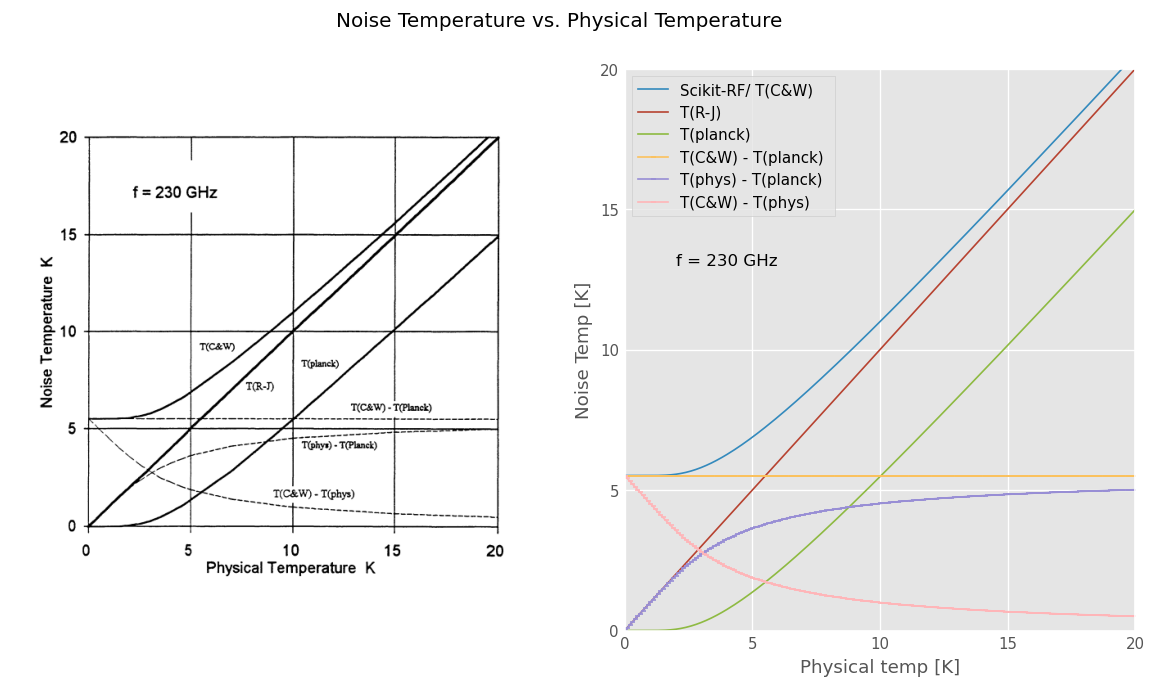

In [3]:
#This code is in the newly added NetworkNoiseCov module
sys2 = rf.NetworkNoiseCov
temps = npy.linspace(.0003,20,201)
Tn = sys2.Tnoise(230e9,temps)


figure(0, figsize = [12,6])

#Figure 1 from ref [4]
subplot(1,2,1)
img = imread('images/Kerr_n_Feldman_Fig1.png')
axis('off')
imshow(img)

#scikit-rf vs. kTB comparison. As described in the references. T(C&W) is the modern accepted convention
subplot(1,2,2)
plt.text(2, 13, 'f = 230 GHz', fontsize=10)
plot(temps, Tn, label=r'Scikit-RF/ T(C&W)')
plot(temps, temps, label=r'T(R-J)')
plot(temps, Tn - (h_PLANK*230e9/(2*K_BOLTZMANN)), label=r'T(planck)')
plot(temps, h_PLANK*230e9/(2*K_BOLTZMANN)*np.ones_like(temps), marker = '_' ,label=r'T(C&W) - T(planck) ')
plot(temps, temps - (Tn - (h_PLANK*230e9/(2*K_BOLTZMANN))), marker = '_' ,label=r'T(phys) - T(planck)')
plot(temps, Tn - temps, marker = '_' ,label=r'T(C&W) - T(phys)')
plt.ylabel('Noise Temp [K]')
plt.xlabel('Physical temp [K]')
plt.suptitle('Noise Temperature vs. Physical Temperature')
legend()
plt.ylim([0,20])
plt.yticks([0,5,10,15,20])
plt.xlim([0,20])
plt.xticks([0,5,10,15,20])
plt.show()

The above figure on the left above is an excerpt from [4] fig. 1. On the right is the same data replicated. 

## Noise Covariance in Multiport Systems (T0 = 290 K)

Next we will explore the results in the Garcia-Garcia [1] paper. This will confirm that the correct noise temperature and noise figure for a variety of sinlge port and two port elements. It will be shown that scikit-rf noise covariance package meets these papers results. Though the calculations for the multi network  covariance were used from [2] and [5]. 

It should be noted that the references [2] and [5] still use the KTB noise model, however this has been remedied in scikit-rf by replaceing Tphys with T(C&W) in the papers calulations. 

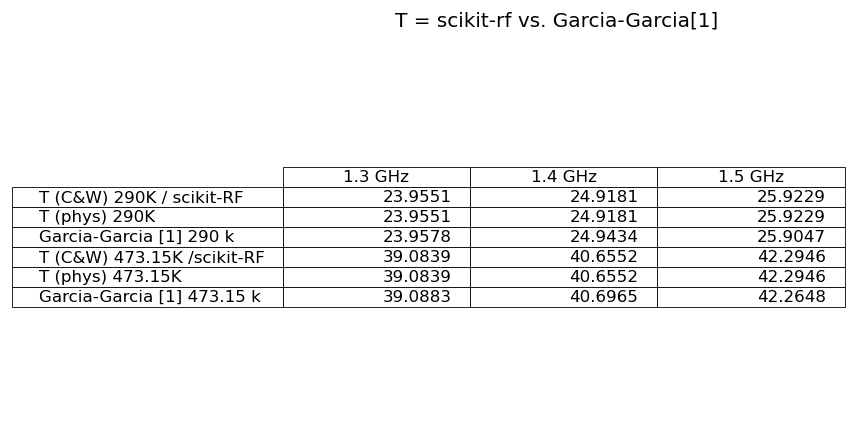

In [3]:
# 3 frequency points to correspond to TABLE 1 in [1]
frequency = rf.Frequency(start=1.3, stop=1.5, npoints=3, unit='GHz')

#This is an ideal attenuator model recently added to scikit-rf 
#Its s-paramters will be changed to better reflect ref [1]
TL2 = rf.noisyComponents.Attenuator(1, frequency=frequency)

TL2.s[:,0,0] = TL2.s[:,1,1] =  [0.0267*np.exp(1j*(-81.549)*np.pi/180), 0.0259*np.exp(1j*(-87.7234)*np.pi/180), 0.0248*np.exp(1j*(-93.8733)*np.pi/180)]

TL2.s[:,1,0] = TL2.s[:,0,1] =  [(0.9607+5e-5)*np.exp(-1j*(-82.8598)*np.pi/180), 0.9593*np.exp(-1j*(-89.2338)*np.pi/180), 0.9578*np.exp(-1j*(-95.6076)*np.pi/180)]

#recalculate noise after changing the S-parameters
TL2.noise_source(T0 = 290)

#calculate T0. This should be incorporated into scikit-rf somewhere as a funtion in a class
A_temps = npy.identity(npy.shape(TL2.s)[1])
A_temps[0,0] = 1
A_temps[1,1] = 0

kb_SAS1 = K_BOLTZMANN*npy.matmul(TL2.s,npy.matmul(A_temps,npy.conjugate(TL2.s.swapaxes(1, 2))))

T_CW_290 = np.real(TL2.cs[:,1,1]/(kb_SAS1[:,1,1]))
# print('Tn (C&W) 290K: ', np.round(T_CW,3))

sys3 = rf.NetworkNoiseCov
temps = 290
Tn = sys3.Tnoise(frequency.f,temps)

T_PHYS_290 = np.real((TL2.cs[:,1,1]*(290/Tn))/(kb_SAS1[:,1,1]))
# print('Tn (phys) 290K: ', np.round(T_PHYS,3))

TL2.noise_source(T0 = 473.15)
T_CW_473P15 = np.real(TL2.cs[:,1,1]/(kb_SAS1[:,1,1]))

sys3 = rf.NetworkNoiseCov
temps = 473.5
Tn = sys3.Tnoise(frequency.f,temps)
T_PHYS_473P5 = np.real((TL2.cs[:,1,1]*(473.5/Tn))/(kb_SAS1[:,1,1]))

table = np.zeros((6,3))

table[0,:] = np.round(T_CW_290,4)
table[1,:] = np.round(T_PHYS_290,4)
table[2,:] = [23.9578,24.9434,25.9047] 
table[3,:] = np.round(T_CW_473P15,4)
table[4,:] = np.round(T_PHYS_473P5,4)
table[5,:] = [39.0883,40.6965,42.2648] 
plt.figure()

collabel=("1.3 GHz", "1.4 GHz", "1.5 GHz")
rowlabel=("T (C&W) 290K / scikit-RF", "T (phys) 290K", "Garcia-Garcia [1] 290 k","T (C&W) 473.15K /scikit-RF", "T (phys) 473.15K", "Garcia-Garcia [1] 473.15 k")
suptitle('T = scikit-rf vs. Garcia-Garcia[1]')
axis('tight')
axis('off')
the_table = plt.table(cellText=table,colLabels=collabel,rowLabels=rowlabel,loc='center')
plt.show()

In the above calculation it can be seen that the data does not match up exacly with Garcia,Garcia [1] TABLE I. This is most likely a rounding error, possibly in the paper, as substituting in the physical temperature also does not yeild a difference in the results. Also, a change of 5e-5 in the return loss or insertion loss can yield a change of 1e-2 in the final calculaiton. A QUCs or ADS comparison is probably warranted here. 


## Equivalent Two-port using power splitters

Again, from Garcia-Garcia an equivalent two port will be constructed using power splitters with ports totaling M and N where M > N To show that the co-variance C = kb*T*(1-(M*a*b)^2) where M is number of ports on the smaller of the two combiners, alpha is the losses on the N way combiner, and n is the loss on the M way combiner. You can compare this to reference [1] section VIII B. It appears to correlate well with the Garcia-Garcia prediction!  

/Users/megwynne/repos/scikit-rf/skrf/mathFunctions.py:165: RuntimeWarning: divide by zero encountered in log10
  out = 20 * npy.log10(input)
/Users/megwynne/opt/anaconda3/envs/p8_rf/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


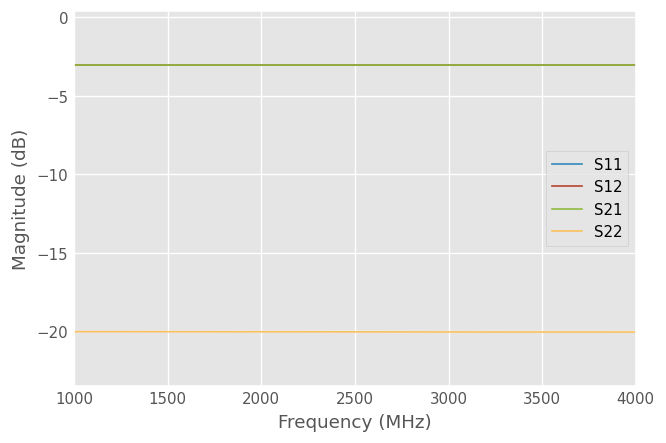

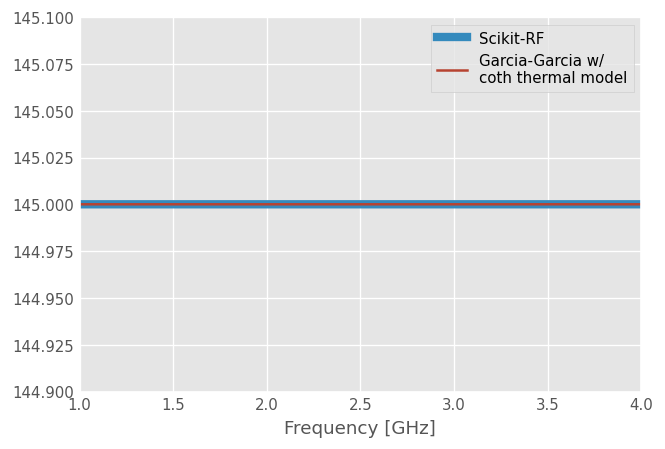

In [4]:
frequency = rf.Frequency(start=1000, stop=4000, npoints=6, unit='MHz')


#using a generic delay load for the example, I chose coaxial because...why not
coax1mm = Coaxial(frequency, z0=50, Dint=0.44e-3, Dout=1.0e-3, sigma=1e8)
load = coax1mm.delay_load(0.2, 21e-3, 'm', z0=50, embed=True)

#convert Network to a NoisyNetwork
load = rf.NoisyNetwork(load)
load.noise_source(source ='passive')

load1 = load
load2 = load

M = 2
N = 4

M_port = rf.noisyComponents.Wilkinson_Nport(M, frequency=frequency, loss_db = 0, T0=290)
N_port = rf.noisyComponents.Wilkinson_Nport(N, frequency=frequency,  loss_db = 0, T0=290)

GEX = rf.MultiNoisyNetworkSystem()

GEX.add(M_port, r'wilkinson_M')
GEX.add(N_port, r'wilkinson_N')
GEX.add(load1, r'load1')
GEX.add(load2, r'load2')

GEX.connect(r'wilkinson_M', 2, r'wilkinson_N', 2)
GEX.connect(r'wilkinson_M', 3, r'wilkinson_N', 3)
GEX.connect(r'wilkinson_N', 4, r'load1', 1)
GEX.connect(r'wilkinson_N', 5, r'load2', 1)

GEX.external_port(r'wilkinson_N', 1, external_port_number=2)
GEX.external_port(r'wilkinson_M', 1, external_port_number=1)


# calculate and return the resulting network
G_example = GEX.reduce()

plt.figure()
G_example.plot_s_db()

plt.figure()
plt.plot(frequency.f/1e9, G_example.cs[:,0,0]/(K_BOLTZMANN),linewidth = 5, label = 'Scikit-RF')

Tn = sys3.Tnoise(frequency.f,290)
plt.plot(frequency.f/1e9, Tn*(1-(M/np.sqrt(N*M))**2), linewidth = 1.5, label = 'Garcia-Garcia w/ \ncoth thermal model')
plt.xlabel('Frequency [GHz]')
#plt.ylabel('$$')

plt.ylim([144.9,145.1])

plt.legend()
plt.show()


## And now to justify the title of this ipython notebook we will perform a multi-port, multi-temperature thermal example.

we will setup and experiment that performs in a cryogenic multi-port environment. This example is based on the ADMX RUN 2A RF Layout (see figure below). 
  

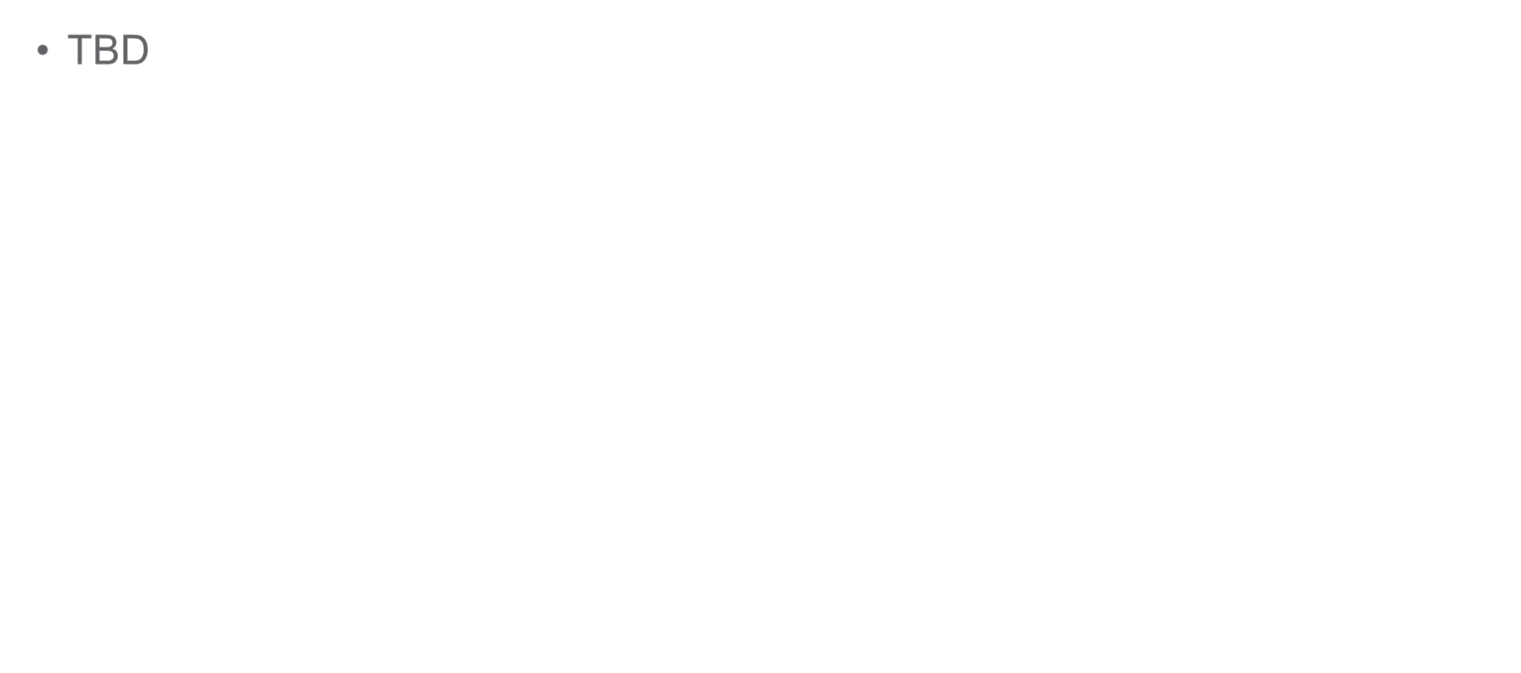

In [5]:
figure(figsize=(16,16))
subplot(1,1,1)
img = imread('images/ADMX_RUN_2A_RF_LAYOUT.PNG')
axis('off')
imshow(img)

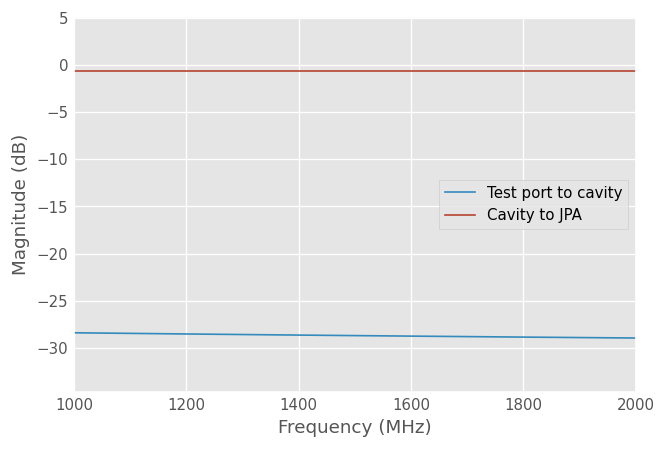

In [6]:
frequency = rf.Frequency(start=1000, stop=2000, npoints=6, unit='MHz')


admx_coax = Coaxial(frequency, z0=50, Dint=0.000652328, Dout=0.0022, epsilon_r=2.1, tan_delta=0.003, sigma=6.14E+07)

#########################################################################################################################
# Create Test port run for 1 leg (total of 4). 
#########################################################################################################################

cable_40K = admx_coax.line(0.7, 'm', embed=True)

# Convert Network to NoisyNetwork
cable_40K = rf.NoisyNetwork(cable_40K)
cable_40K.noise_source(source ='passive', T0=40)

cable_10K = admx_coax.line(0.7, 'm', embed=True)

cable_10K = rf.NoisyNetwork(cable_10K)
cable_10K.noise_source(source ='passive', T0=10)

Attn1_4K = rf.noisyComponents.Attenuator(0.5, frequency=frequency, T0 = 4)
Attn2_1K = rf.noisyComponents.Attenuator(3, frequency=frequency, T0 = 1)
Attn3_0p7K = rf.noisyComponents.Attenuator(10, frequency=frequency, T0 = .7)
Attn4_0p4K = rf.noisyComponents.Attenuator(3, frequency=frequency, T0=.4)
Attn5_0p1K = rf.noisyComponents.Attenuator(10, frequency=frequency, T0=.1)

cable_0p1K = admx_coax.line(1.5, 'm', embed=True)

cable_0p1K = rf.NoisyNetwork(cable_0p1K)
cable_0p1K.noise_source(source ='passive', T0=0.1)

Circ1 = rf.noisyComponents.Circulator(0.6, frequency = frequency, iso_db = 18, T0 = .090)


Test_port_1leg= rf.MultiNoisyNetworkSystem()

Test_port_1leg.add(cable_40K, r'1_cable')
Test_port_1leg.add(cable_10K, r'2_cable')
Test_port_1leg.add(Attn1_4K, r'3_atten')
Test_port_1leg.add(Attn2_1K, r'4_atten')
Test_port_1leg.add(Attn3_0p7K, r'5_atten')
Test_port_1leg.add(Attn4_0p4K, r'6_atten')
Test_port_1leg.add(Attn5_0p1K, r'7_atten')
Test_port_1leg.add(cable_0p1K, r'8_atten')
Test_port_1leg.add(Circ1, r'9_circ')


Test_port_1leg.connect(r'1_cable', 2, r'2_cable', 1)
Test_port_1leg.connect(r'2_cable', 2, r'3_atten', 1)
Test_port_1leg.connect(r'3_atten', 2, r'4_atten', 1)
Test_port_1leg.connect(r'4_atten', 2, r'5_atten', 1)
Test_port_1leg.connect(r'5_atten', 2, r'6_atten', 1)
Test_port_1leg.connect(r'6_atten', 2, r'7_atten', 1)
Test_port_1leg.connect(r'7_atten', 2, r'8_atten', 1)
Test_port_1leg.connect(r'7_atten', 2, r'8_atten', 1)
Test_port_1leg.connect(r'8_atten', 2, r'9_circ', 2)

####
#bug fixed!!
###
Test_port_1leg.external_port(r'9_circ' , 1, 1) # to cold electronics
Test_port_1leg.external_port(r'9_circ' , 3, 2) # cavity
Test_port_1leg.external_port(r'1_cable', 1, 3) # test port


# # the verify function make sure that all the ports have been asigned and that everything is consistant for the reduction algorithm
(en, e) = Test_port_1leg.verify()
#print(e)
for error in e:
    print(error)
# print("Total number of Errors: " + str(en))

Test_port = Test_port_1leg.reduce()

plt.figure()
Test_port.plot_s_db(m = 1,n = 2, label = 'Test port to cavity')
Test_port.plot_s_db(m = 0,n = 1, label = 'Cavity to JPA')

plt.show()

#calculate T0. This should be incorporated into scikit-rf somewhere as a funtion in a class
# A_temps = npy.identity(npy.shape(Test_port.s)[1])
# A_temps[0,0] = 0
# A_temps[1,1] = 1
# A_temps[2,2] = 1

# kb_SAS1 = K_BOLTZMANN*npy.matmul(Test_port.s,npy.matmul(A_temps,npy.conjugate(Test_port.s.swapaxes(1, 2))))

# T_CW_P2 = np.real(Test_port.cs[:,0,0]/(kb_SAS1[:,0,0]))

# plt.figure()
# #plot(frequency.f/1e9,T_CW_P1, label = 'T0 P1')
# plot(frequency.f/1e9,T_CW_P2, label = 'T0 P1')
# legend()
# plt.show()


/Users/megwynne/repos/scikit-rf/skrf/mathFunctions.py:165: RuntimeWarning: divide by zero encountered in log10
  out = 20 * npy.log10(input)


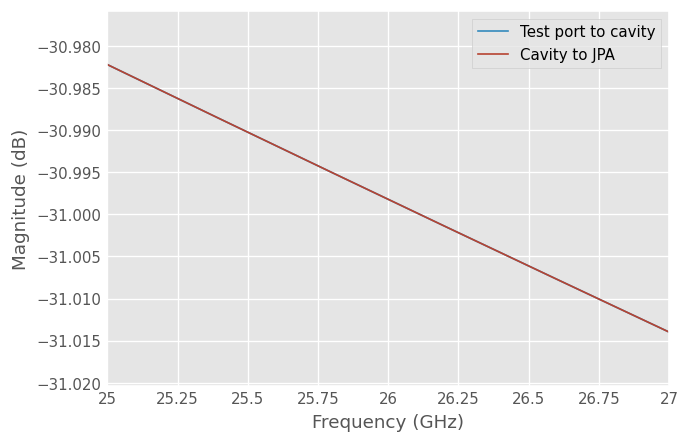

In [19]:
##changing the above code for some of our parameters
frequency = rf.Frequency(start=25, stop=27, npoints=6, unit='GHz')
#changed to our freq 

admx_coax = Coaxial(frequency, z0=50, Dint=0.000652328, Dout=0.0022, epsilon_r=2.1, tan_delta=0.003, sigma=6.14E+07)
#havent changed this part yet
#########################################################################################################################
# Create Test port run for 1 leg (total of 4). 
#########################################################################################################################

cable_4K = admx_coax.line(0.3, 'm', embed=True)
##changed to 4k and to .3m
# Convert Network to NoisyNetwork
cable_4K = rf.NoisyNetwork(cable_4K)
cable_4K.noise_source(source ='passive', T0=4)

# cable_10K = admx_coax.line(0.7, 'm', embed=True)

# cable_10K = rf.NoisyNetwork(cable_10K)
# cable_10K.noise_source(source ='passive', T0=10)
##commenting these out for now
Attn1_4K = rf.noisyComponents.Attenuator(20, frequency=frequency, T0 = 4)
Attn2_40K = rf.noisyComponents.Attenuator(10, frequency=frequency, T0 = 40)
##dont actually know it what order the 10 and 20 db will be but we can use this to test!
# Attn3_0p7K = rf.noisyComponents.Attenuator(10, frequency=frequency, T0 = .7)
# Attn4_0p4K = rf.noisyComponents.Attenuator(3, frequency=frequency, T0=.4)
# Attn5_0p1K = rf.noisyComponents.Attenuator(10, frequency=frequency, T0=.1)

# cable_0p1K = admx_coax.line(1.5, 'm', embed=True)

# cable_0p1K = rf.NoisyNetwork(cable_0p1K)
# cable_0p1K.noise_source(source ='passive', T0=0.1)

Circ1 = rf.noisyComponents.Circulator(.25, frequency = frequency, iso_db = 30, T0 = 4)
#not totally sure ab these numbers first of all I have negative values only, also why dont we have more s parameters also shouldnt this be stepping thru diff vals @diff freqs

Test_port_1leg= rf.MultiNoisyNetworkSystem()

Test_port_1leg.add(cable_4K, r'1_cable')
#Test_port_1leg.add(cable_10K, r'2_cable')
Test_port_1leg.add(Attn1_4K, r'3_atten')
Test_port_1leg.add(Attn2_40K, r'4_atten')
# Test_port_1leg.add(Attn3_0p7K, r'5_atten')
# Test_port_1leg.add(Attn4_0p4K, r'6_atten')
# Test_port_1leg.add(Attn5_0p1K, r'7_atten')
# Test_port_1leg.add(cable_0p1K, r'8_atten')
Test_port_1leg.add(Circ1, r'9_circ')


Test_port_1leg.connect(r'9_circ', 3, r'3_atten', 1)
Test_port_1leg.connect(r'3_atten', 2, r'1_cable', 1)
Test_port_1leg.connect(r'1_cable', 2, r'4_atten', 1)
# Test_port_1leg.connect(r'4_atten', 2, r'5_atten', 1)
# Test_port_1leg.connect(r'5_atten', 2, r'6_atten', 1)
# Test_port_1leg.connect(r'6_atten', 2, r'7_atten', 1)
# Test_port_1leg.connect(r'7_atten', 2, r'8_atten', 1)
# Test_port_1leg.connect(r'7_atten', 2, r'8_atten', 1)
# Test_port_1leg.connect(r'8_atten', 2, r'9_circ', 2)

####
#bug fixed!!
###
Test_port_1leg.external_port(r'9_circ' , 1, 1) # to cold electronics
Test_port_1leg.external_port(r'9_circ' , 2, 3) # cavity
Test_port_1leg.external_port(r'4_atten', 2, 2) # test port
#this was a shot in the dark last time and probs will be again

# # the verify function make sure that all the ports have been asigned and that everything is consistant for the reduction algorithm
(en, e) = Test_port_1leg.verify()
#print(e)
for error in e:
    print(error)
# print("Total number of Errors: " + str(en))

Test_port = Test_port_1leg.reduce()

plt.figure()
Test_port.plot_s_db(m = 1,n = 2, label = 'Test port to cavity')
Test_port.plot_s_db(m = 0,n = 1, label = 'Cavity to JPA')

plt.show()

#calculate T0. This should be incorporated into scikit-rf somewhere as a funtion in a class
# A_temps = npy.identity(npy.shape(Test_port.s)[1])
# A_temps[0,0] = 0
# A_temps[1,1] = 1
# A_temps[2,2] = 1

# kb_SAS1 = K_BOLTZMANN*npy.matmul(Test_port.s,npy.matmul(A_temps,npy.conjugate(Test_port.s.swapaxes(1, 2))))

# T_CW_P2 = np.real(Test_port.cs[:,0,0]/(kb_SAS1[:,0,0]))

# plt.figure()
# #plot(frequency.f/1e9,T_CW_P1, label = 'T0 P1')
# plot(frequency.f/1e9,T_CW_P2, label = 'T0 P1')
# legend()
# plt.show()


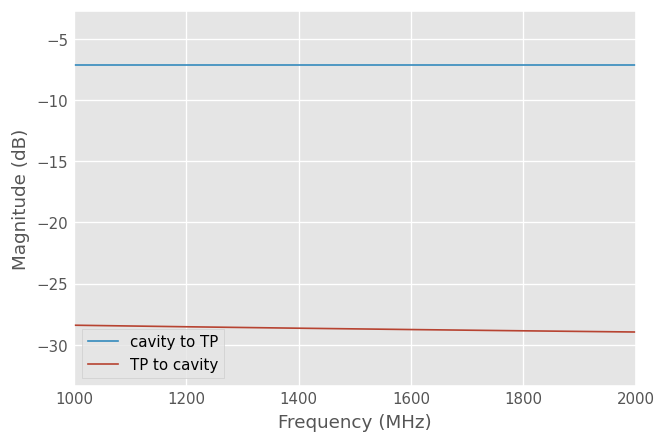

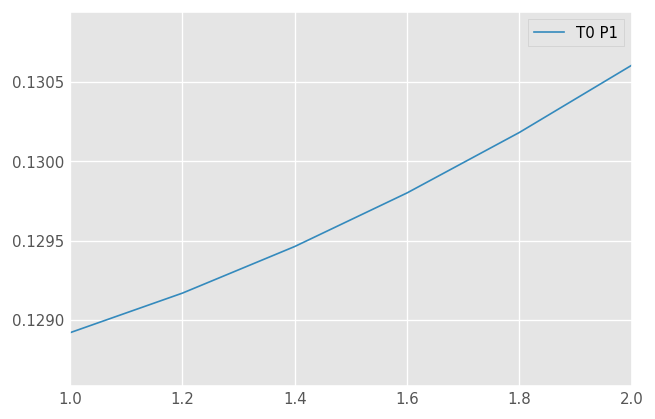

In [7]:
#########################################################################################################################
# Wilkinson Divider 4-way
#########################################################################################################################

combiner_fway = rf.noisyComponents.Wilkinson_Nport(4, frequency=frequency, loss_db = 0.5, T0=.1)

Cavity_passive_sum = rf.MultiNoisyNetworkSystem()

Cavity_passive_sum.add(combiner_fway, r'1_combiner_4way')
Cavity_passive_sum.add(Test_port, r'test_port_1')
Cavity_passive_sum.add(Test_port, r'test_port_2')
Cavity_passive_sum.add(Test_port, r'test_port_3')
Cavity_passive_sum.add(Test_port, r'test_port_4')


Cavity_passive_sum.connect(r'1_combiner_4way', 2, r'test_port_1', 1)
Cavity_passive_sum.connect(r'1_combiner_4way', 3, r'test_port_2', 1)
Cavity_passive_sum.connect(r'1_combiner_4way', 4, r'test_port_3', 1)
Cavity_passive_sum.connect(r'1_combiner_4way', 5, r'test_port_4', 1)


####
# There is a bug here ports are not being renamed correctly
###
Cavity_passive_sum.external_port(r'1_combiner_4way', 1, 1) # to cold electronics
Cavity_passive_sum.external_port(r'test_port_1', 2, 2) #cavity
Cavity_passive_sum.external_port(r'test_port_1', 3, 6) #test port
Cavity_passive_sum.external_port(r'test_port_2', 2, 3) #cavity
Cavity_passive_sum.external_port(r'test_port_2', 3, 7) #test port
Cavity_passive_sum.external_port(r'test_port_3', 2, 4) #cavity
Cavity_passive_sum.external_port(r'test_port_3', 3, 8) #test port
Cavity_passive_sum.external_port(r'test_port_4', 2, 5) #cavity
Cavity_passive_sum.external_port(r'test_port_4', 3, 9) #test port

ADMX_passive = Cavity_passive_sum.reduce()

plt.figure()
ADMX_passive.plot_s_db(m=0 , n = 1, label= 'cavity to TP')
ADMX_passive.plot_s_db(m=1 , n = 5, label= 'TP to cavity')

plt.show()


#calculate T0. This should be incorporated into scikit-rf somewhere as a funtion in a class
A_temps = npy.identity(npy.shape(ADMX_passive.s)[1])
A_temps[0,0] = 0
A_temps[1,1] = 1
A_temps[2,2] = 1
A_temps[2,2] = 1
A_temps[2,2] = 1
A_temps[2,2] = 1
A_temps[2,2] = 1
A_temps[2,2] = 1
A_temps[2,2] = 1
A_temps[2,2] = 1

kb_SAS1 = K_BOLTZMANN*npy.matmul(ADMX_passive.s,npy.matmul(A_temps,npy.conjugate(ADMX_passive.s.swapaxes(1, 2))))

ADMX_T0 = np.real(ADMX_passive.cs[:,0,0]/(kb_SAS1[:,0,0]))

plt.figure()
#plot(frequency.f/1e9,T_CW_P1, label = 'T0 P1')
plot(frequency.f/1e9,ADMX_T0 + .100, label = 'T0 P1')
legend()
plt.show()




## References

[1] Q. García-García, “Noise in lossless microwave multiports: Noise in Lossless Microwave Multiports,” Int J RF and Microwave Comp Aid Eng, vol. 14, no. 2, pp. 99–110, Mar. 2004, doi: 10.1002/mmce.10122.

[2] S. W. Wedge and D. B. Rutledge, “Noise waves and passive linear multiports,” IEEE Microw. Guid. Wave Lett., vol. 1, no. 5, pp. 117–119, May 1991, doi: 10.1109/75.89082.

[4] A. R. Kerr’ and M. J. Feldman, “Receiver Noise Temperature, the Quantum Noise Limit, and the Role of the Zero-Point Fluctuations,” p. 11, 1997.

[5] S. W. Wedge and D. B. Rutledge, “Wave techniques for noise modeling and measurement,” IEEE Trans. Microwave Theory Techn., vol. 40, no. 11, pp. 2004–2012, Nov. 1992, doi: 10.1109/22.168757.

[6] J. R. Anthony R. Kerr, “Thermal Noise and Noise Measurements - A 2010 Update,” IEEE Microwave Magazine, no. October 2010, pp. 40–52, Oct. 2010.

In [8]:

#ntwkCirc1 = rf.components.Circulator(0.5, frequency = frequency, T0 = .090)
# ntwkCirc2 = rf.components.Circulator(0.5, frequency = frequency, T0 = .090)




# ntwkC = rf.cascade_2port(ntwkAttn1_4000mK, ntwkAttn2_1000mK)

# sys = rf.MultiNetworkSystem()

# # add all the networks to the system
# sys.add(ntwkAttn1_4000mK, r'attn_4K')
# sys.add(ntwkAttn2_1000mK, r'attn_1K')
# sys.add(ntwkAttn_700mK, r'attn_0p7K')
# sys.add(ntwkAttn_400mk, r'attn_0p4K')
# sys.add(ntwkAttn_100mk, r'attn_0p1K')
# sys.add(ntwkCirc1, r'inj_circ')
# sys.add(ntwkCirc1, r'jpa_circ')

# # make all the connections between the elements
# sys.connect(r'attn_4K', 2, r'attn_1K', 1)
# sys.connect(r'attn_1K', 2, r'attn_0p7K', 1)
# sys.connect(r'attn_0p7K', 2, r'attn_0p4K', 1)
# sys.connect(r'attn_0p4K', 2, r'attn_0p1K', 1)
# sys.connect(r'attn_0p1K', 2, r'inj_circ', 1)
# sys.connect(r'inj_circ', 3, r'jpa_circ', 1)


# # set the external port numbers, for this example the reduced network is a two-port network. The following is used to identify port 1 and port 2 of that resulting network.
# sys.external_port(r'attn_4K', 1, external_port_number=1)
# sys.external_port(r'inj_circ', 2, external_port_number=2)
# sys.external_port(r'jpa_circ', 2, external_port_number=3)
# sys.external_port(r'jpa_circ', 3, external_port_number=4)

# # the verify function make sure that all the ports have been asigned and that everything is consistant for the reduction algorithm
# (en, e) = sys.verify()
# print(e)
# for error in e:
#     print(error)
# print("Total number of Errors: " + str(en))

# # calculate and return the resulting network
# ntwk = sys.reduce()
# # print(ntwk)
# # print(20*npy.log10(npy.abs(ntwk.s)))
# # print(ntwk.cs)



# A_temps = npy.identity(npy.shape(ntwk.s)[1])
# A_temps[0,0] = 1
# A_temps[1,1] = 1
# A_temps[2,2] = 1
# A_temps[3,3] = 1
# A_temps[0,0] = 0
# kb_SAS1 = K_BOLTZMANN*npy.matmul(ntwk.s,npy.matmul(A_temps,npy.conjugate(ntwk.s.swapaxes(1, 2))))
# # print('T1 sas: ', kb_SAS1 [:,0,0])
# T1 = ntwk.cs[:,0,0]/kb_SAS1[:,0,0]
# print('T1: ', T1)

# A_temps = npy.identity(npy.shape(ntwk.s)[1])
# A_temps[0,0] = 1
# A_temps[1,1] = 1
# A_temps[2,2] = 1
# A_temps[3,3] = 1
# A_temps[1,1] = 0
# kb_SAS1 = K_BOLTZMANN*npy.matmul(ntwk.s,npy.matmul(A_temps,npy.conjugate(ntwk.s.swapaxes(1, 2))))

# T2 = ntwk.cs[:,1,1]/kb_SAS1[:,1,1]
# # print('T2 sas: ', A_temps1)
# print('T2: ', T2)

# A_temps = npy.identity(npy.shape(ntwk.s)[1])
# A_temps[0,0] = 1
# A_temps[1,1] = 1
# A_temps[2,2] = 1
# A_temps[3,3] = 1
# A_temps[2,2] = 0
# kb_SAS1 = K_BOLTZMANN*npy.matmul(ntwk.s,npy.matmul(A_temps,npy.conjugate(ntwk.s.swapaxes(1, 2))))

# T3 = ntwk.cs[:,2,2]/kb_SAS1[:,2,2]
# print('T3: ', T3)

# A_temps = npy.identity(npy.shape(ntwk.s)[1])
# A_temps[0,0] = 1
# A_temps[1,1] = 1
# A_temps[2,2] = 1
# A_temps[3,3] = 1
# A_temps[3,3] = 0
# kb_SAS1 = K_BOLTZMANN*npy.matmul(ntwk.s,npy.matmul(A_temps,npy.conjugate(ntwk.s.swapaxes(1, 2))))

# T4 = ntwk.cs[:,3,3]/kb_SAS1[:,3,3]
# print('T4: ', T4)